# samv2

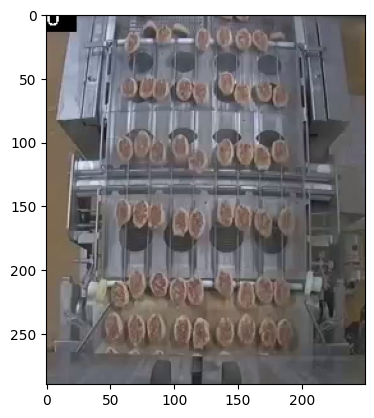

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image

img_path = "../../data/processed/meatballs/images/train/frame_000000.PNG"

img = Image.open(img_path)
img = np.array(img.convert("RGB"))

img = img[10:300, 200:450]

plt.imshow(img)

In [9]:
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.build_sam import build_sam2
from sam2.utils.misc import variant_to_config_mapping

model = build_sam2(
    variant_to_config_mapping["small"],
    "../models/sam2_hiera_small.pt",
)

mask_generator = SAM2AutomaticMaskGenerator(
    model,
    points_per_side=32,           # Increased from default 32
    pred_iou_thresh=0.7,          # Lowered from default 0.8
    stability_score_thresh=0.85,  # Lowered from default 0.95
    box_nms_thresh=0.6,           # Lowered from default 0.7
    )



In [10]:
masks = mask_generator.generate(img)

In [11]:
print(masks[0]['segmentation'].shape)
print(img.shape)


(290, 250)
(290, 250, 3)


In [12]:
from typing import Optional, Union, List, Dict

import numpy as np
from PIL import Image


def show_masks_fixed(
    image: np.ndarray,
    masks: Union[np.ndarray, List[Dict]],
    scores: Optional[np.ndarray] = None,
    alpha: Optional[float] = 0.5,
    display_image: Optional[bool] = True,  # Changed default to True
    only_best: Optional[bool] = True,
    autogenerated_mask: Optional[bool] = False,
) -> Image.Image:
    """
    Display segmentation masks on an image.
    
    Parameters:
        image (np.ndarray): Input image as a numpy array.
        masks (np.ndarray or List[Dict]): Either a numpy array of masks or a list of dictionaries
                                         with "segmentation" and "area" keys.
        scores (np.ndarray, optional): Confidence scores for masks.
        alpha (float, optional): Transparency of masks. Default is 0.5.
        display_image (bool, optional): Whether to display masks on the input image. Default is False.
        only_best (bool, optional): Whether to only display the mask with highest score. Default is True.
        autogenerated_mask (bool, optional): Whether masks are in autogenerated format. Default is False.
        
    Returns:
        PIL.Image.Image: Image with overlaid masks
    """
    # Handle sorting by scores if provided
    if scores is not None and not autogenerated_mask:
        # Sort masks by their scores
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]

    # Get dimensions from the input
    if display_image:
        # Use the input image dimensions
        if image.ndim == 3:  # Color image
            h, w = image.shape[:2]
        else:  # Grayscale image
            h, w = image.shape
    elif autogenerated_mask:
        # For autogenerated masks, get dimensions from the first mask
        if isinstance(masks, list) and masks and 'segmentation' in masks[0]:
            h, w = masks[0]['segmentation'].shape
        else:
            raise ValueError("Autogenerated masks should be a list of dictionaries with 'segmentation' key")
    else:
        # For regular masks, get dimensions from the mask array
        if masks.ndim == 3:  # Multiple masks
            h, w = masks.shape[1:]
        else:  # Single mask
            h, w = masks.shape

    # Prepare the output image
    if display_image:
        # Convert input image to PIL and ensure RGBA mode
        if image.dtype == np.uint8:
            output_image = Image.fromarray(image)
        else:
            output_image = Image.fromarray((image * 255).astype(np.uint8))
            
        if output_image.mode != 'RGBA':
            output_image = output_image.convert('RGBA')
    else:
        # Create a new blank image
        output_image = Image.new(mode="RGBA", size=(w, h), color=(0, 0, 0, 0))  # Fully transparent
        
        # If we have the original image, blend it in even when display_image is False
        # This ensures masks are displayed on top of the original image
        if image is not None:
            img_pil = Image.fromarray(image if image.dtype == np.uint8 else (image * 255).astype(np.uint8))
            if img_pil.mode != 'RGBA':
                img_pil = img_pil.convert('RGBA')
            # Resize if needed
            if img_pil.size != output_image.size:
                img_pil = img_pil.resize((w, h))
            output_image = img_pil.copy()

    # Process each mask
    if autogenerated_mask:
        # Sort by area if autogenerated
        if isinstance(masks, list) and masks and 'area' in masks[0]:
            masks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    
    # Iterate through masks
    mask_count = len(masks) if isinstance(masks, list) else masks.shape[0]
    for i in range(mask_count):
        if autogenerated_mask:
            if isinstance(masks, list) and 'segmentation' in masks[i]:
                mask = masks[i]["segmentation"]
            else:
                raise ValueError("Expected masks to be a list of dicts with 'segmentation' key when autogenerated_mask=True")
        else:
            if masks.ndim > 2:
                mask = masks[i]
                if mask.ndim > 2:  # Handle extra dimensions
                    mask = mask.squeeze()
            else:
                mask = masks  # Single mask case

        # Generate a random color with specified alpha value
        color = np.concatenate(
            (np.random.randint(0, 256, size=3), [int(alpha * 255)]), axis=0
        )

        # Create an RGBA image for the mask
        # Ensure mask has values 0-1 for binary mask
        if mask.dtype != np.bool_:
            if np.max(mask) > 1.0:
                mask = (mask > 0).astype(np.uint8)
            else:
                mask = (mask > 0.5).astype(np.uint8)
        
        # Print debug info (uncomment if needed)
        # print(f"Mask shape: {mask.shape}, Output image size: {output_image.size}")
        
        # Ensure mask dimensions match output_image dimensions (width×height in PIL)
        expected_h, expected_w = output_image.size[1], output_image.size[0]
        if mask.shape[0] != expected_h or mask.shape[1] != expected_w:
            # Resize mask to match output_image dimensions
            # Note: NumPy and PIL have different dimension ordering
            mask_resized = np.zeros((expected_h, expected_w), dtype=mask.dtype)
            # Copy values where possible
            min_h = min(mask.shape[0], expected_h)
            min_w = min(mask.shape[1], expected_w)
            mask_resized[:min_h, :min_w] = mask[:min_h, :min_w]
            mask = mask_resized
                
        mask_image = Image.fromarray((mask * 255).astype(np.uint8)).convert("L")
        mask_colored = Image.new("RGBA", mask_image.size, tuple(color))
        mask_overlay = Image.new("RGBA", mask_image.size, (0, 0, 0, 0))
        mask_image = Image.composite(mask_colored, mask_overlay, mask_image)

        # Overlay mask on the output image
        output_image = Image.alpha_composite(output_image, mask_image)

        # Exit if specified to only display the best mask
        if only_best:
            break

    return output_image

In [13]:
output_mask = show_masks_fixed(image = img, masks = masks, scores=None, only_best=False, autogenerated_mask=True)

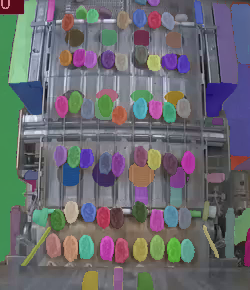

In [14]:
output_mask

# Sparse models

In [2]:
from master.model import MultiLayerFeatureKNN


In [ ]:

# Initialize with specific layers and PCA variance threshold
knn = MultiLayerFeatureKNN(layers=[2, 4, 6, 8], pca_variance=0.95)

# Train with just positive examples (no need for labels)
knn.fit(positive_images, positive_masks)

# Predict returns masks that are similar to training examples
filtered_masks, similarity_scores = knn.predict(test_image, candidate_masks)

# Always call cleanup when done to prevent memory leaks
knn.cleanup()

# Dataloader